In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# insample = pd.read_csv(
#     os.path.join(
#         r'2024_10_07 17-55-55 Deep Neural Network 3oosRMSE',
#         r'2024_10_07 17-55-55 Deep Neural Network 3oosRMSE insample_results.csv'
#     )
# )

# outofsample_results = pd.read_csv(
#     os.path.join(
#         r'2024_10_07 17-55-55 Deep Neural Network 3oosRMSE',
#         r'2024_10_07 17-55-55 Deep Neural Network 3oosRMSE outofsample_results.csv'
#     )
# )


##################
# training start #
##################

Wed Oct  9 08:43:48 2024


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual


importing dataset(s)...



loading: 100%|███████████████████████████████████████████████████████████████████████| 882/882 [00:17<00:00, 50.96it/s]



preparing data...


         spot_price  strike_price       barrier  days_to_maturity  \
count  4.446559e+06  4.446559e+06  4.446559e+06      4.446559e+06   
mean   1.407845e+03  1.406800e+03  1.407680e+03      3.305861e+02   
min    9.851700e+02  8.866530e+02  4.925850e+02      6.000000e+01   
25%    1.333240e+03  1.315775e+03  1.045324e+03      9.000000e+01   
50%    1.418380e+03  1.406704e+03  1.409008e+03      3.600000e+02   
75%    1.496000e+03  1.501407e+03  1.750725e+03      5.400000e+02   
max    1.565180e+03  1.721698e+03  2.347770e+03      7.200000e+02   
std    1.008005e+02  1.301131e+02  4.475153e+02      2.415886e+02   

       barrier_price     rebate  dividend_rate  risk_free_rate         theta  \
count   4.446559e+06  4446559.0   4.446559e+06    4.446559e+06  4.446559e+06   
mean    5.374085e+01        0.0   2.044764e-02    4.000000e-02  4.955989e-02   
min     2.593117e-08        0.0   1.779800e-02    4.000000e-02  1.992058e-02   
25%     2.380417e+00        0.0   1.8

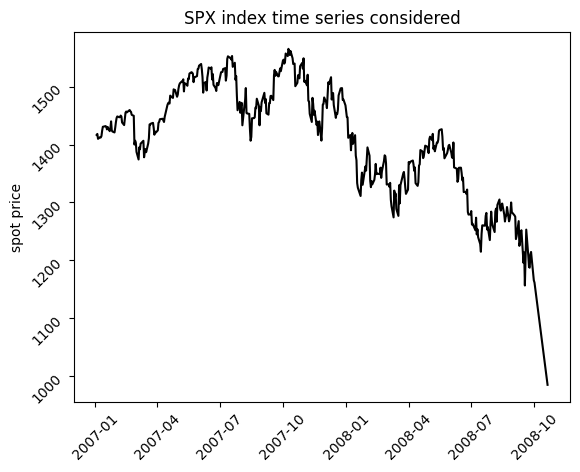

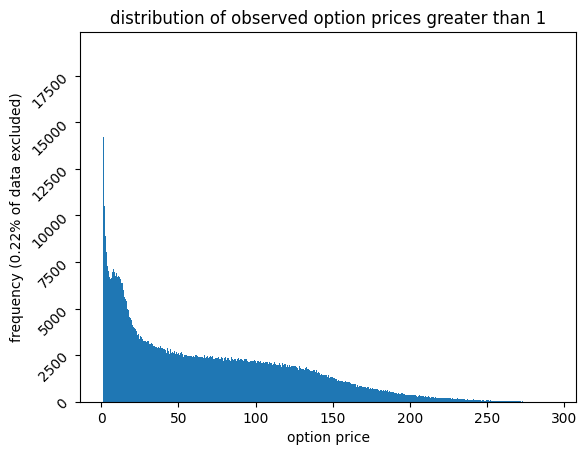

test size: 1.0%
random state: None
maximum iterations: 1000

target: 
observed_price

features: 
['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier', 'barrier_type_name', 'w']

feature transformer(s):
('StandardScaler', StandardScaler(), ['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier'])

('OneHotEncoder', OneHotEncoder(sparse_output=False), ['barrier_type_name', 'w'])

target transformer(s):
StandardScaler()

#################
# training data #
#################
         spot_price  strike_price       barrier  days_to_maturity  \
count  3.937983e+06  3.937983e+06  3.937983e+06      3.937983e+06   
mean   1.428923e+03  1.427824e+03  1.428591e+03      3.308515e+02   
min    1.214910e+03  1.093419e+03  6.074550e+02      6.000000e+01   
25%    1.362140e+03  1.344011e+03  1.070848e+03      9.000000e+01   
50%    1.446900e+03 

<Figure size 640x480 with 0 Axes>

In [3]:
from train_main import model_fit, outofsample_results, insample_results

In [53]:
maturities = outofsample_results['days_to_maturity'].unique().tolist()
barrier_type_names = outofsample_results['barrier_type_name'].unique().tolist()
ws = outofsample_results['w'].unique().tolist()
print(f"\nmaturities:\n{maturities}")
print(f"\ntypes:\n{barrier_type_names}\n{ws}\n")


maturities:
[60, 90, 180, 360, 540, 720]

types:
['DownOut', 'DownIn', 'UpOut', 'UpIn']
['put', 'call']



In [55]:
by_wbtypet = outofsample_results.copy().set_index(['w','barrier_type_name','days_to_maturity'])

RMSE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        RMSE.loc[t,b] = np.sqrt(np.average((by_wbtypet.loc[(slice(None), b, t),'outofsample_error'])**2))
print(f"\nRMSE:\n{RMSE}")


MAE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        MAE.loc[t,b] = np.average(np.abs(by_wbtypet.loc[(slice(None), b, t),'outofsample_error']))
print(f"\nMAE:\n{MAE}")


RMSE:
      DownOut    DownIn     UpOut      UpIn
60   6.653319  7.432815  6.555291  5.255256
90   6.080862  6.391906  5.554924  4.727756
180  6.074189  6.527830  5.442617  5.926101
360  5.545142  8.490470  4.670086  6.869724
540  6.024411  8.094578  4.257807  8.065510
720  6.667369  6.513764  4.514706  8.390063

MAE:
      DownOut    DownIn     UpOut      UpIn
60   4.066343  3.692213  3.845208  2.577180
90   3.747760  3.105852  3.099100  2.348229
180  4.003494  3.226386  3.444049  3.250670
360  3.471622  4.723932  3.135787  4.089892
540  3.713242  4.502829  2.834379  4.698232
720  4.131871  3.850131  2.608987  4.875641


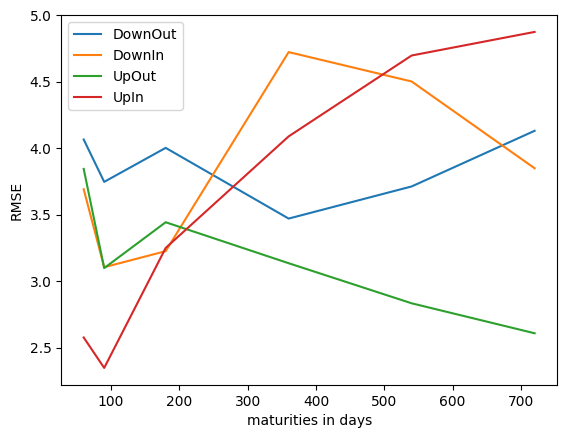

In [56]:
plt.figure()
plt.plot(MAE.loc[:, 'DownOut'], label='DownOut')
plt.plot(MAE.loc[:, 'DownIn'], label='DownIn')
plt.plot(MAE.loc[:, 'UpOut'], label='UpOut')
plt.plot(MAE.loc[:, 'UpIn'], label='UpIn')
plt.xlabel('maturities in days')
plt.ylabel('RMSE')
plt.legend()
plt.show()
plt.close()